In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import corner
from tqdm import tqdm_notebook

# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# H2b - Variational method with Metropolis

## Task 1

The energy is given as

$$ E_L = -4 + \frac{(\hat{r_1}-\hat{r_2}) \cdot (r_1 - r_2) }{r_{12}(1+\alpha r_{12})^2} - \frac{1}{r_{12}(1 + \alpha r_{12})^3} - \frac{1}{4(1+\alpha r_{12})^4} + \frac{1}{r_{12}},$$

where

$$ (\hat{r_1}-\hat{r_2}) \cdot (r_1 - r_2) = \Delta \hat{r}\cdot (x_1-x_2, y_1-y_2, z_1-z_2) = \Delta \hat{r} \cdot (\Delta x, \Delta y, \Delta z) = $$

$$ = \Delta x + \Delta y + \Delta z $$

$\Delta \hat{x}$ denotes a unit vector in the direction of $\Delta x$.

To find the density $\rho(r)$ we need to determine $r$. How do we do this for our system where we have two particles with different position vectors.

(100000, 2)


Text(0, 0.5, 'Trace')

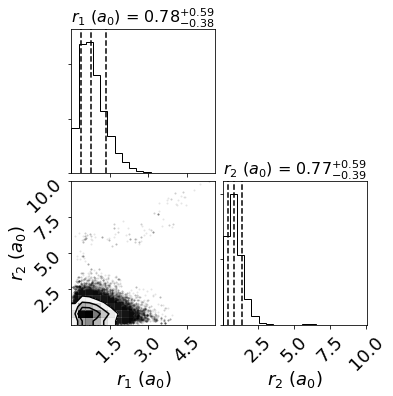

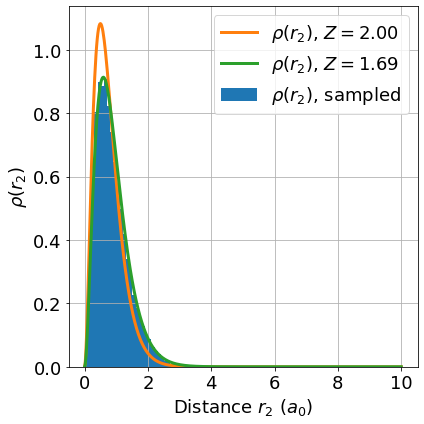

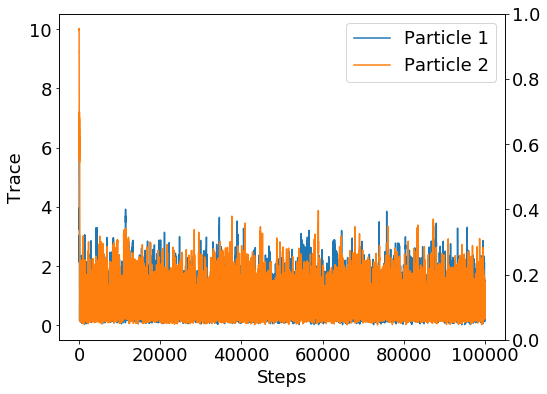

In [2]:
# Load rho data - and compare to central field approximation
def centralField(r, Z):
    return Z**3 * 4*r**2 * np.exp(-2*Z*r)

data = np.loadtxt('task1and2/rho.dat')
r2 = data[:,1]

Zs = [2, 27/16]

r = np.linspace(0,10, 500)

r_samples = np.vstack([data[:,0], data[:,1]]).T
print(r_samples.shape)

# Corner plot

figure = corner.corner(r_samples, labels=[r"$r_1$ ($a_0$)", r"$r_2$ ($a_0$)"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16})
plt.savefig("corner_plot.png")

# plot 
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(r2,100, density=True, label=r'$\rho(r_2)$, sampled')
for Z in Zs:
    ax.plot(r, centralField(r, Z), linewidth=3, label=fr'$\rho(r_2)$, $Z=${Z:.2f}')
ax.legend(loc='best')
ax.grid()
ax.set_xlabel(r'Distance $r_2$ ($a_0$)')
ax.set_ylabel(r'$\rho(r_2)$')
plt.tight_layout()
plt.savefig("sampled_probability.png")

# Plot trace
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data[:,0], label='Particle 1')
ax.plot(data[:,1], label='Particle 2')
ax_twin = ax.twinx()
ax.legend(loc='best')
ax.set_xlabel("Steps")
ax.set_ylabel("Trace")

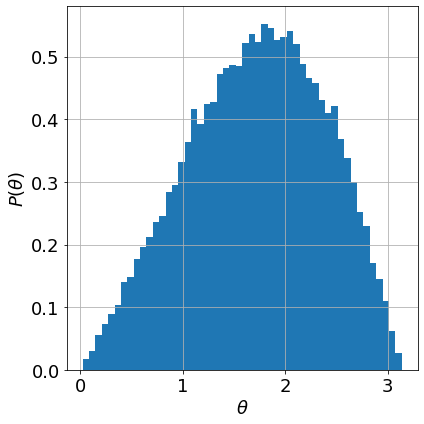

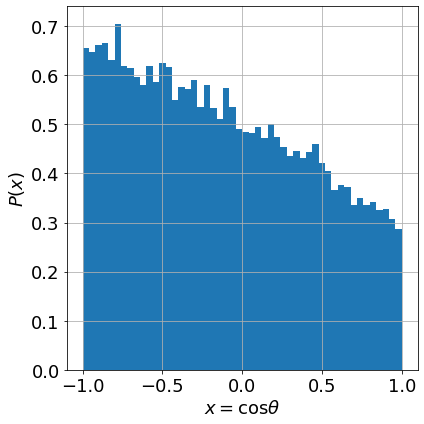

In [10]:
# Plot theta data

# Load rho data 
data = np.loadtxt('task1and2/theta.dat')

# plot 
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(data[:,0], 50, density=True)
ax.grid()
ax.set_ylabel(r'$P(\theta)$')
ax.set_xlabel(r'$\theta$')
plt.tight_layout()
plt.savefig("theta_sin.png")

fig, ax = plt.subplots(figsize=(6,6))
ax.hist(np.cos(data[:,0]), 50, density=True)
ax.grid()
ax.set_ylabel(r'$P(x)$')
ax.set_xlabel(r'$x = \cos{\theta}}$')
plt.tight_layout()
plt.savefig("theta_x.png")

We see a higher sampled region for $\cos{\theta} \approx -1$ than for 1. This could be due to the walk starting out in this region, and thus taking more steps there. Since $p(\theta)$ should be uniform, the choice of starting points makes a difference now that we don't have any warm up steps.

Average energy is: -2.8804 a.u.


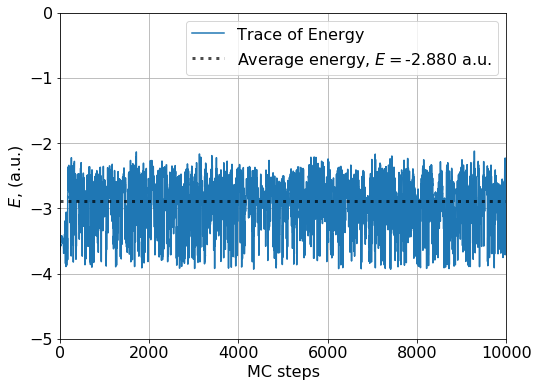

In [72]:
# Plot energy data 

# Load rho data 
data = np.loadtxt('task1and2/energy.dat')
avg_E = np.mean(data)
print(f'Average energy is: {avg_E:.4f} a.u.')

# plot 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data, label='Trace of Energy')
ax.axhline(avg_E, linewidth=3, color='k', linestyle=':', alpha=0.7, label=fr'Average energy, $E=${avg_E:.3f} a.u.')
# ax.axvline(200, color='r', linestyle='--', alpha=0.7, label=fr'Equilibration end')
ax.grid()
ax.set_ylabel(r'$E$, (a.u.)')
ax.set_xlabel(r'MC steps')
ax.legend(loc='best')
ax.set_xlim(0,10000)
ax.set_ylim(-5,-0)
plt.savefig("energy.png")

# Task 2 - equilibration and statistical inneficiency

Average energy is: -2.8804 a.u.


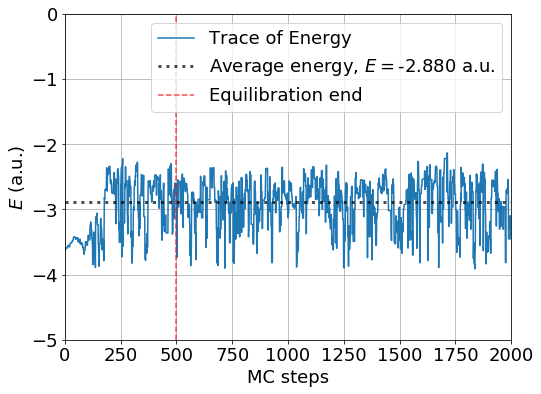

In [24]:
# Plot energy data 

# Load rho data 
data = np.loadtxt('task1and2/energy.dat')
avg_E = np.mean(data)
print(f'Average energy is: {avg_E:.4f} a.u.')

# plot 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data, label='Trace of Energy')
ax.axhline(avg_E, linewidth=3, color='k', linestyle=':', alpha=0.7, label=fr'Average energy, $E=${avg_E:.3f} a.u.')
ax.axvline(500, color='r', linestyle='--', alpha=0.7, label=fr'Equilibration end')
ax.grid()
ax.set_ylabel(r'$E$ (a.u.)')
ax.set_xlabel(r'MC steps')
ax.legend(loc='best')
ax.set_xlim(0,2000)
ax.set_ylim(-5,0)
plt.savefig("equilibration.png")

In [ ]:
# Plot the correlation function 
data = np.loadtxt('task1and2/corr_fcn.dat')
limit = np.exp(-2)
sc = (np.abs(data[:,1] - limit)).argmin()
print('Statistical inefficiency: ', sc)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data[:,0], data[:,1], label='Correlation function')
ax.axhline(limit, color='k', linestyle='--', alpha=0.7, label=fr'Limit for s')
ax.axvline(sc, color='r', linestyle='--', alpha=0.7, label=fr'Statistical inefficiency')

ax.set_xlim(0,100)
ax.legend(loc='best')
ax.grid()
ax.set_ylabel(r'$\Phi_k$')
ax.set_xlabel(r'k')
plt.savefig("corr_fcn.png")

In [ ]:
# Plot the lower limit of the statistical inefficiency
data = np.loadtxt('task1and2/stat_inef.dat')
lower_bound = round(0.1*len(data[:,1]))
upper_bound = round(0.33*len(data[:,1]))
mean = np.mean(data[lower_bound:upper_bound,1])
print(mean_interval, mean)


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data[:,0], data[:,1], label=r'Lower bound of $s$')
ax.axhline(mean, color='r', linestyle='--', alpha=0.7, label=fr'Statistical inefficiency')
ax.axvline(lower_bound, color='k', linestyle='--', alpha=0.7, label=fr'Limit for mean calculation')
ax.axvline(upper_bound, color='k', linestyle='--', alpha=0.7)

ax.legend(loc='best')
ax.grid()
ax.set_ylabel(r'Lower bound of $s$')
ax.set_xlabel(r'Block size $B$')
plt.savefig("stat_inef.png")

# Task 3 - Minimum value of E

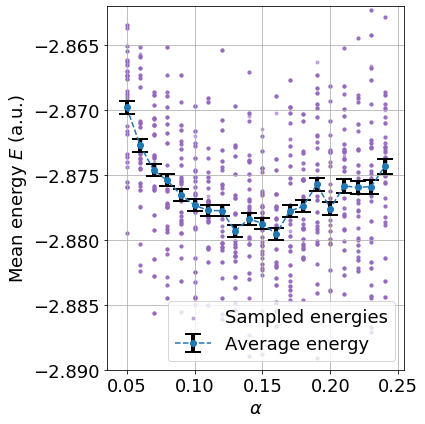

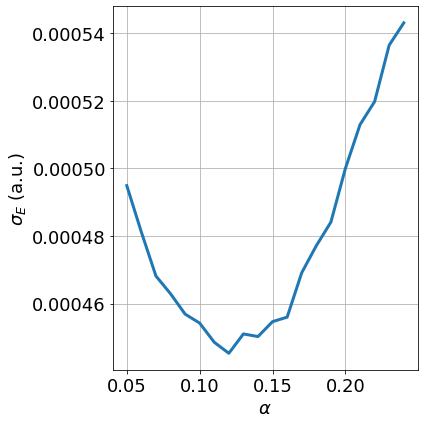

In [45]:
# Load energy and statistical inefficiency data
data = np.loadtxt('task3.dat')

# Calculate error bars - using statistical inefficiency, varE and N
varE = data[:,4]*data[:,2]/data[:,3]  # Usage of 

# Use multiple values for each alpha to minimize error
alphas = []
E = []
errE = []

for alpha in np.unique(data[:,0]):
    idx = np.where(data[:,0]==alpha)
    average_meanE = np.sum(data[idx,1])/len(idx[0]) # Mean of mean energies
    average_varE = np.sum(varE[idx])/len(idx[0]) # Mean of variance in energies 
    alphas.append(alpha)
    E.append(average_meanE)
    errE.append(np.sqrt(average_varE/len(idx[0])))

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], color='C4', marker='.', alpha=0.5, label='Sampled energies')
ax.errorbar(alphas, E, yerr=errE, elinewidth=4, ecolor='k', alpha=1, capsize=8, capthick=2, fmt='C0o--', label='Average energy')
ax.legend(loc='lower right')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'Mean energy $E$ (a.u.)')
ax.grid()
ax.set_ylim(-2.890, -2.862)
plt.tight_layout()
plt.savefig("optimum_alpha_avg.png")

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(alphas, errE, linewidth=3)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\sigma_E$ (a.u.)')
ax.grid()
plt.tight_layout()
plt.savefig("optimum_alpha_err.png")

In [63]:
alpha = np.copy(alphas)
En = np.copy(E)
varE = np.copy(errE)
idx = np.argsort(En)

print(alpha[idx])
print(En[idx])
print(varE[idx])

[0.16 0.13 0.15 0.14 0.17 0.12 0.11 0.2  0.18 0.1  0.09 0.22 0.23 0.21
 0.19 0.08 0.07 0.24 0.06 0.05]
[-2.87955825 -2.87930457 -2.87873059 -2.87835873 -2.87777101 -2.87774112
 -2.87772147 -2.87757827 -2.87740079 -2.87731408 -2.8765328  -2.87595252
 -2.87588062 -2.87582761 -2.87570823 -2.87541102 -2.87463291 -2.87433291
 -2.87269937 -2.86975796]
[0.00045598 0.00045101 0.00045465 0.00045024 0.00046911 0.00044529
 0.00044855 0.00050003 0.00047711 0.00045421 0.00045688 0.00051975
 0.00053645 0.00051293 0.00048408 0.00046291 0.00046814 0.00054304
 0.00048113 0.00049489]


# Task 4

We will use a damped steepest descent method to optimize $\alpha$:

$$ \alpha_{p+1} = \alpha_p - \gamma_p \nabla_\alpha E(\alpha)$$
where $E(\alpha)$ is the metropolis sampled average energy for a fix $\alpha$. We approximate the gradient by:

$$\nabla_\alpha E(\alpha) = 2[\left<E_L(R) \nabla_\alpha \ln{\Psi_T(R)}\right> - \left<E_L(R)\right> \left<\nabla_\alpha \ln{\Psi_T(R)}\right>]$$

$E_L(R)$ is the energy as a fuction of sampled positions, and $\Psi_T(R)$ is the trial wavefunction. The averages are taken over the path of configuration spaces, i.e. the over the sampled points during the metropolis algorithm. Thus, in order to change $\alpha$ we need to run one whole metropolis sampling of the function, so the method is fairly expensive.

The constant $\gamma_p$ is given as: 

$$ \gamma_p = Ae^{-\beta} = [A=1] = e^{-\beta}. $$

Finally, we need the gradient (derivative) of the log of the trial wavefunction with respect to $\alpha$.

$$ \Psi_T(R) = e^{-2r_1}e^{-2r_2}e^{\frac{r_{12}}{2(1+\alpha r_{12})}} \rightarrow $$

$$ \ln{\Psi_T(R)} = -2r_1 - 2 r_2 + \frac{r_{12}}{2(1+\alpha r_{12})} \rightarrow $$

$$ \nabla_\alpha \ln{\Psi_T(R)} = -\frac{r_{12}^2}{2(1+\alpha r_{12})^2} $$


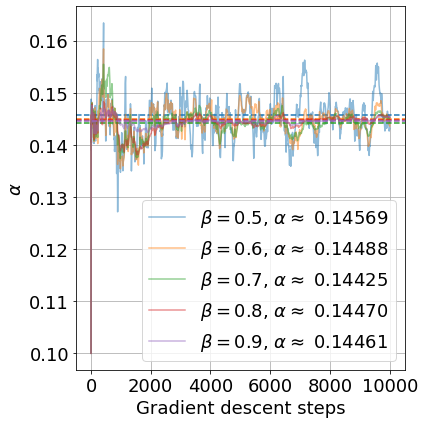

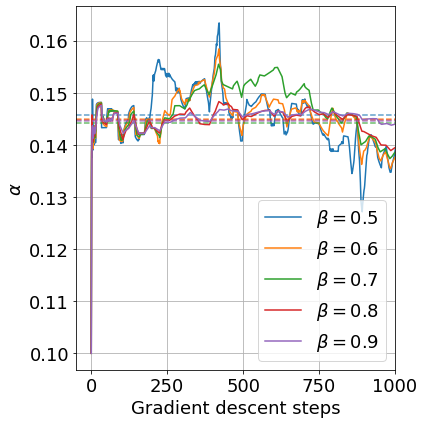

In [73]:
data = np.loadtxt('task4.dat')

fig, ax = plt.subplots(figsize=(6,6))
betas = data[0,:]

for idx, beta in enumerate(betas):
    # Don't plot the beta - first element
    halflength = (int)((len(data)-2)/2 + 2)
    meanE = np.mean(data[halflength:,idx])
    ax.plot(data[1:,idx], color=f'C{idx}', alpha=0.5, label=fr'$\beta=${beta}, $\alpha \approx $ {meanE:.5f}')  
    ax.axhline(meanE, color=f'C{idx}', linestyle='--', alpha=1)
    
ax.grid()
ax.legend(loc='lower right')
ax.set_xlabel('Gradient descent steps')
ax.set_ylabel(r'$\alpha$')
plt.tight_layout()
plt.savefig("sgd_full.png")

fig, ax = plt.subplots(figsize=(6,6))
betas = data[0,:]

for idx, beta in enumerate(betas):
    # Don't plot the beta - first element
    halflength = (int)((len(data)-2)/2 + 2)
    meanE = np.mean(data[halflength:,idx])
    ax.plot(data[1:,idx], color=f'C{idx}', alpha=1, label=fr'$\beta=${beta}')  
    ax.axhline(meanE, color=f'C{idx}', linestyle='--', alpha=0.7)
    
ax.grid()
ax.legend(loc='lower right')
ax.set_xlabel('Gradient descent steps')
ax.set_ylabel(r'$\alpha$')
ax.set_xlim(-50,1000)
plt.tight_layout()
plt.savefig("sgd_zoom.png")

# Task 5

In [78]:
# Load data
data = np.loadtxt("task5_test.dat")

# Calculate variance of E by correcting with the statistical inneficiency
varE = data[:,4] * data[:,2] / data[:,3]/len(data)

# Take average of mean energies and variances
meanE = np.mean(data[:,1])
errE = np.sqrt(np.mean(varE))

print(fr'Carefully calculated value is $E_0 \approx$ {meanE:.6f}$\pm${errE:.6} a.u.')

Carefully calculated value is $E_0 \approx$ -2.876242$\pm$0.000137476 a.u.
